# FVCOM horizontal slice at fixed depth

In [1]:
%matplotlib inline

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pyugrid
import iris
import warnings

from ciso import zslice

In [2]:
#url = 'http://crow.marine.usf.edu:8080/thredds/dodsC/FVCOM-Nowcast-Agg.nc'
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(url)

In [4]:
var = cubes.extract_strict('sea_water_potential_temperature')[-1, ...]  # Last time step.

In [5]:
lon = var.coord(axis='X').points
lat = var.coord(axis='Y').points

In [6]:
var

<iris 'Cube' of sea_water_potential_temperature / (degrees_C) (-- : 40; -- : 53087)>

In [7]:
z3d = var.coord('sea_surface_height_above_reference_ellipsoid').points
var3d = var.data

In [8]:


z0 = -25
isoslice = zslice(var3d, z3d, z0)

In [9]:


# For some reason I cannot tricontourf with NaNs.
isoslice = ma.masked_invalid(isoslice)
vmin, vmax = isoslice.min(), isoslice.max()
isoslice = isoslice.filled(fill_value=-999)

In [10]:


cmap = plt.cm.viridis

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines('50m')
    return fig, ax

In [11]:


ugrid = pyugrid.UGrid.from_ncfile(url)

lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
triangles = ugrid.faces[:]

triang = tri.Triangulation(lon, lat, triangles=triangles)

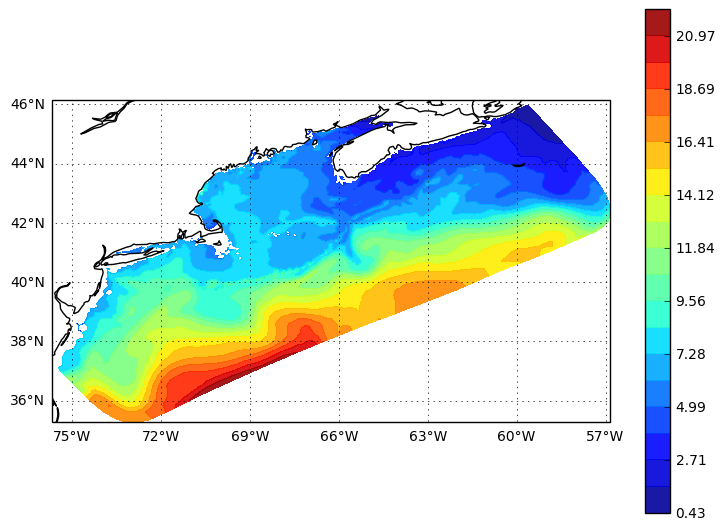

In [12]:
fig, ax = make_map()
extent = [lon.min(), lon.max(),
          lat.min(), lat.max()]
ax.set_extent(extent)

levels = np.linspace(vmin, vmax, 20)

kw = dict(cmap='jet', alpha=0.9, levels=levels)
cs = ax.tricontourf(triang, isoslice, **kw)
kw = dict(shrink=0.5, orientation='vertical')
cbar = fig.colorbar(cs, **kw)